In [1]:
# user guide from https://pmelchior.github.io/scarlet/0-quickstart.html
from  typing import Callable, List, Tuple
from itertools import product, starmap

# Import Packages and setup
import numpy as np
import scarlet
import scarlet.psf as psf
import scarlet.display
from tqdm import tqdm

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import signal

# use a good colormap and don't interpolate the pixels
matplotlib.rc('image', interpolation='none', origin='lower')
plt.style.use("robertsons_rules")

In [2]:
#https://stackoverflow.com/a/46892763/2691018
def gkern(kernlen=21, std=8):
    """Returns a 2D Gaussian kernel array."""
    gkern1d = signal.gaussian(kernlen, std=std).reshape(kernlen, 1)
    gkern2d = np.outer(gkern1d, gkern1d)
    return gkern2d

In [3]:
data = np.load("hsc_cosmos_35.npz")
images = data["images"] # (5, 58, 48)
filters = data["filters"] # ['g', 'r', 'i', 'z', 'y']
catalog = data["catalog"] # List of 2-Tuple, x and y
weights = 1/data["variance"] # (5, 58, 48)
psfs = scarlet.ImagePSF(data["psfs"]) # (5, 43, 43)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


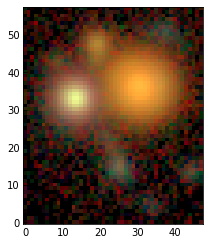

In [4]:
from scarlet.display import AsinhMapping

stretch = 0.2
Q = 10
norm = AsinhMapping(minimum=0, stretch=stretch, Q=Q)

img_rgb = scarlet.display.img_to_rgb(images, norm=norm)
plt.imshow(img_rgb)
plt.show()

In [5]:
model_psf = scarlet.GaussianPSF(sigma=(0.8,)*len(filters))

In [6]:
model_frame = scarlet.Frame(
    images.shape,
    psfs=model_psf,
    channels=filters)

observation = scarlet.Observation(
    images,
    psfs=psfs,
    weights=weights,
    channels=filters).match(model_frame)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


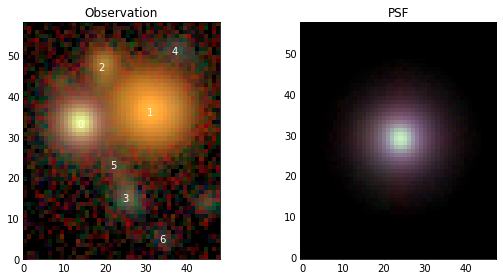

In [7]:
sky_coords = [[src['y'], src['x']] for src in catalog] # y/x!
scarlet.display.show_observation(observation, norm=norm, sky_coords=sky_coords, show_psf=True)
plt.show()

In [7]:
sources = []
for k,src in enumerate(catalog):
    if k == 0:
        new_source = scarlet.PointSource(model_frame, (src['y'], src['x']), observation)
    elif k == 1:
        new_source = scarlet.ExtendedSource(model_frame, (src['y'], src['x']), observation, K=2)
    else:
        new_source = scarlet.ExtendedSource(model_frame, (src['y'], src['x']), observation, compact=True)
    sources.append(new_source)

CPU times: user 1.81 s, sys: 34.4 ms, total: 1.85 s
Wall time: 1.85 s
scarlet ran for 76 iterations to logL = 30420.93855546932


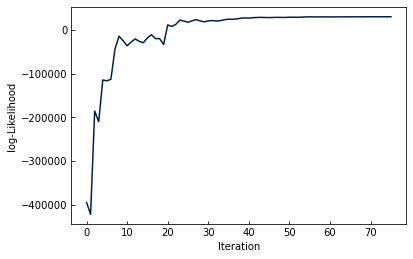

In [9]:
blend = scarlet.Blend(sources, observation)
%time it, logL = blend.fit(100, e_rel=1e-4)
print(f"scarlet ran for {it} iterations to logL = {logL}")
scarlet.display.show_likelihood(blend)
plt.show()

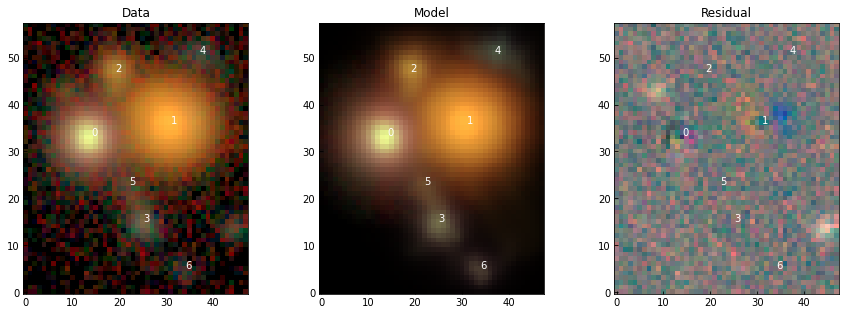

In [10]:
# Compute model
model = blend.get_model()
# Render it in the observed frame
model_ = observation.render(model)
# Compute residual
residual = images-model_

# Create RGB images
model_rgb = scarlet.display.img_to_rgb(model_, norm=norm)
residual_rgb = scarlet.display.img_to_rgb(residual)

# Show the data, model, and residual
fig = plt.figure(figsize=(15,5))
ax = [fig.add_subplot(1,3,n+1) for n in range(3)]
ax[0].imshow(img_rgb)
ax[0].set_title("Data")
ax[1].imshow(model_rgb)
ax[1].set_title("Model")
ax[2].imshow(residual_rgb)
ax[2].set_title("Residual")

for k,src in enumerate(blend):
    if hasattr(src, "center"):
        y,x = src.center
        ax[0].text(x, y, k, color="w")
        ax[1].text(x, y, k, color="w")
        ax[2].text(x, y, k, color="w")
plt.show()

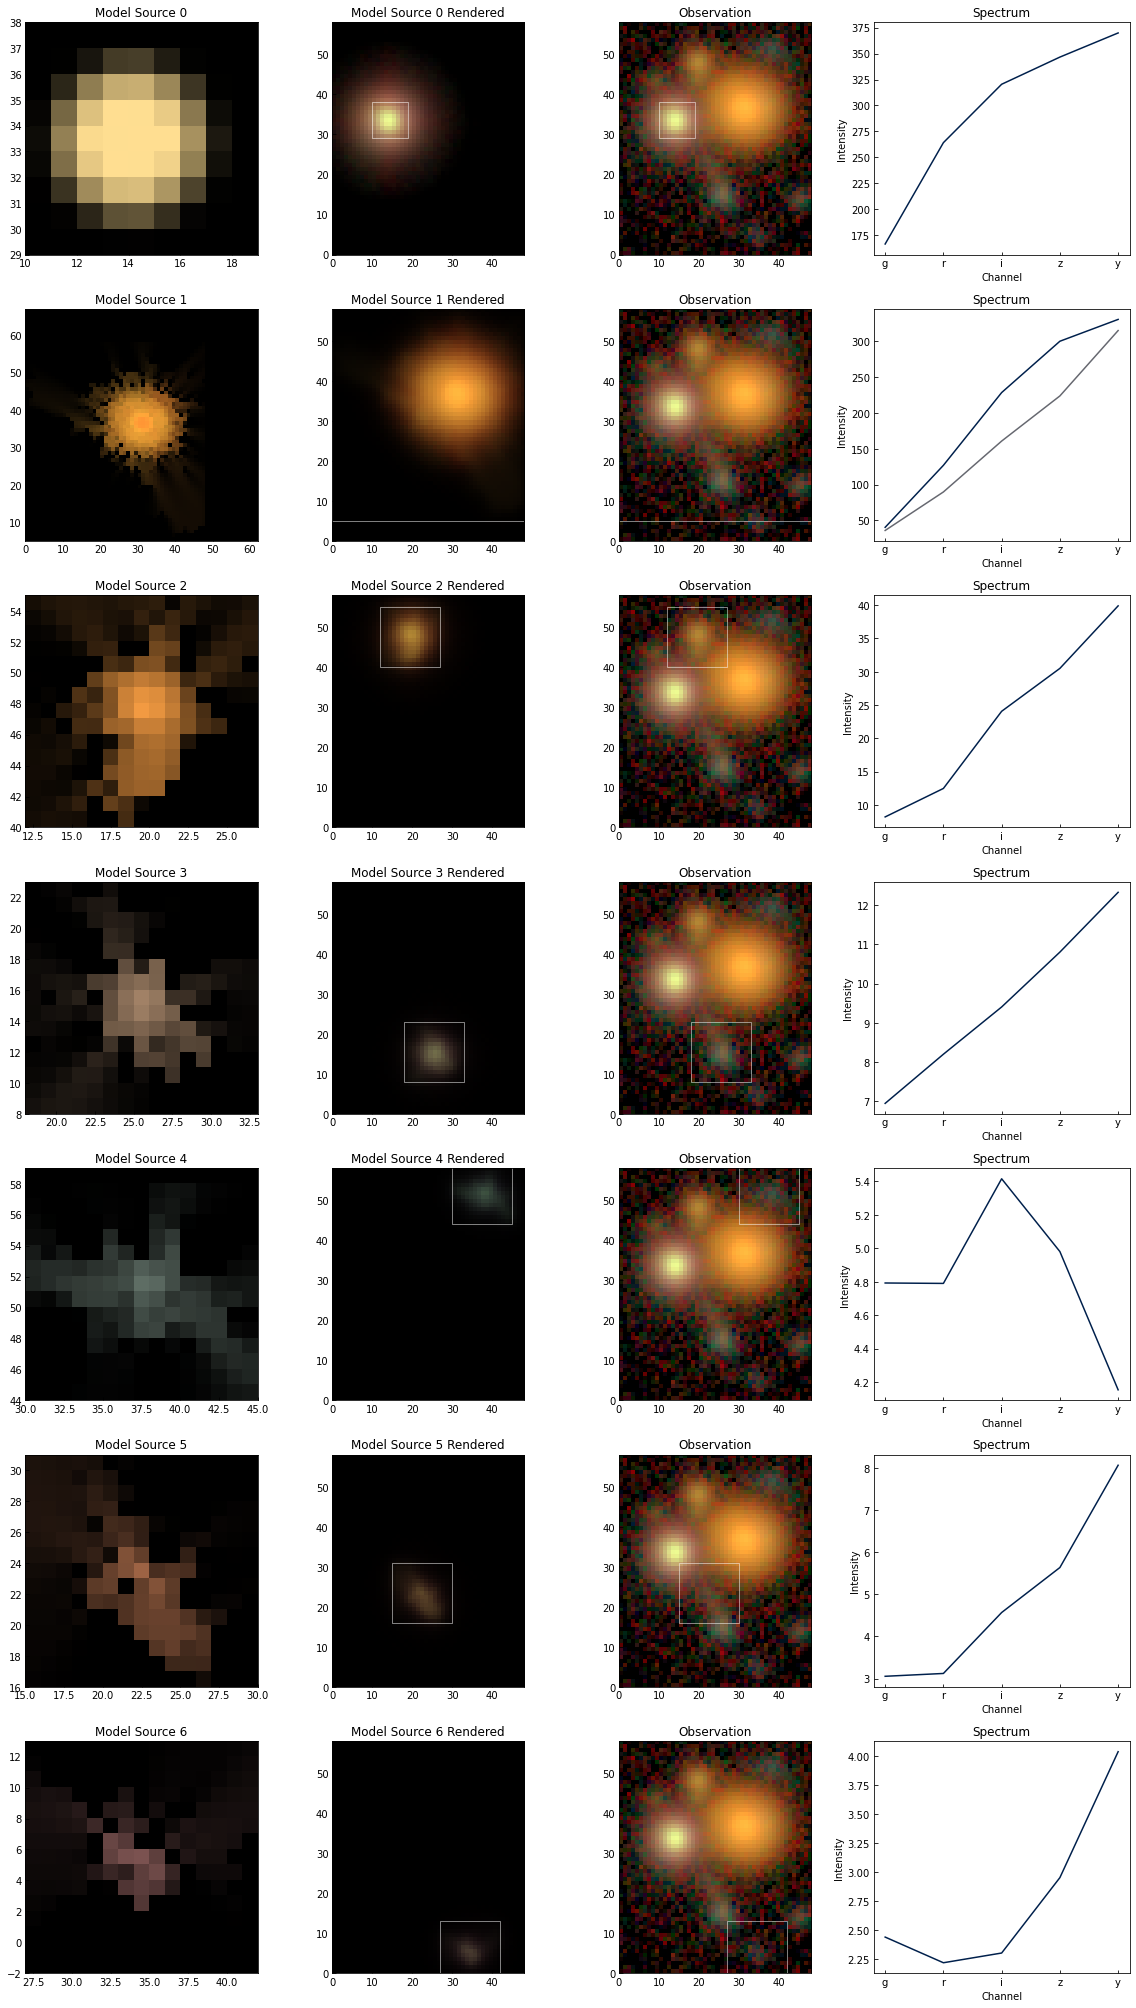

In [26]:
scarlet.display.show_sources(sources,
                             norm=norm,
                             observation=observation,
                             show_model=True,
                             show_rendered=True,
                             show_observed=True,
                             add_markers=False,
                             add_boxes=True
                            )
plt.show()

https://arxiv.org/pdf/1911.10194.pdf

# $\text{Morpheus}^{++}$ Label Idea

The input, $x$, to $\text{Morpheus}^{++}$ is a multiband image with a height $H$, width $W$, and number of bands $B$

$$x_{ijb} \in \mathbb{R}^{H \times W \times B}$$

The label has three components:
- pixel-level morphology, $\mathbb{R}^{n_{\text{classes}}}$
- claim vectors, $\mathbb{R}^{B \times 8 \times 2}$
- claim distribution, $\mathbb{R}^{B \times 9}$ 
- Centerpoint distribution value $\mathbb{R}^{1}$

The first component, morphology, is given by the original morpheus setup.

The claim vectors and claim distribution are new to morpheus and describe deblending

The center of mass distribution value represents whether or not that pixels is a center of mass indicating an instance which the claim vectors and claim distribtution point to

(0.0, 1.0, 0.0, 1.0)

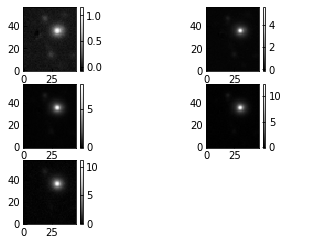

In [27]:
m = observation.render(sources[0].get_model(frame=sources[0].frame))

f, axes = plt.subplots(nrows=3, ncols=2)

# print(m.min(), m.max())

for mdl, ax, img in zip(m, axes.flat, images):

    # print("Model: ", mdl.max(), mdl.min())
    # print("Image: ", img.max(), img.min())
    im = ax.imshow(img-mdl, cmap="Greys_r")
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

axes[-1, -1].axis("off")

In [1]:
model_vals = [observation.render(sources[i].get_model(frame=sources[i].frame)) for i in range(len(sources))]
combined_model = sum(model_vals)
noise_image = images - combined_model

NameError: name 'sources' is not defined

### Center of Mass Distribution

The center of mass distribution indicates individual instances in the image. In https://arxiv.org/pdf/1911.10194.pdf, during training, the center of masses are encoded as a gaussian with standard deviation of 8 pixels

slice(8, 58, None) slice(0, 39, None)
slice(11, 58, None) slice(6, 56, None)
slice(22, 58, None) slice(0, 44, None)
slice(0, 40, None) slice(0, 50, None)
slice(26, 58, None) slice(12, 58, None)
slice(0, 48, None) slice(0, 47, None)
slice(0, 30, None) slice(9, 58, None)


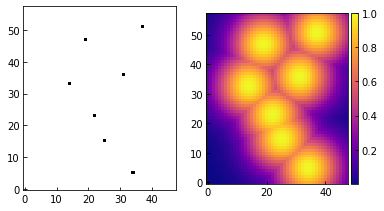

In [29]:
center_point_truth = np.zeros_like(images[0])
center_point_train = np.zeros_like(images[0])

gk_len = 51
gk = gkern(gk_len, 8)
height, width = center_point_train.shape

for src in catalog:
    y, x = int(src["y"]), int(src["x"])
    center_point_truth[y, x]=1
    #half_len = gk_len // 2
    half_len = int((gk_len / 2))
    

    big_ys = slice(
        max(y-half_len, 0),
        min(y+half_len, height)
    )
    
    big_xs = slice(
        max(x-half_len, 0),
        min(x+half_len, height)
    )
    
    g_ys = slice(
        half_len - min(half_len, half_len-(half_len-y)),
        half_len + min(half_len, height-y),
    )
    
    g_xs = slice(
        half_len - min(half_len, half_len-(half_len-x)),
        half_len + min(half_len, width-x),
    )
    
    b = center_point_train[big_ys, big_xs].copy()
    g = gk[g_ys, g_xs].copy()

    print(big_ys, big_xs)
    # print("Point:", y, ", ", x)
    # print(big_ys)
    # print(big_xs)
    # print(b.shape)
    # print(half_len-(half_len-y))
    # print(g_ys)
    # print(half_len-(half_len-x))
    # print(g_xs)
    # print(g.shape)

    # half_len = gk_len // 2
    # ys = slice(y-half_len, y+half_len)
    # xs = slice(x-half_len, x+half_len)
    
    center_point_train[big_ys, big_xs] = np.maximum(g, b)

f, ax = plt.subplots(nrows=1, ncols=2)
ax[0].imshow(center_point_truth, cmap="Greys", origin="lower")
im = ax[1].imshow(center_point_train, cmap="plasma", origin="lower")#, vmin=0, vmax=1)
divider = make_axes_locatable(ax[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
plt.show()

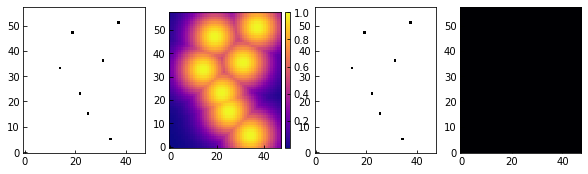

In [30]:
from astropy.io import fits
from skimage.util import view_as_windows
from skimage.feature import peak_local_max
from timeit import timeit

def nms(kernel_size:int, threshold:float, image:np.ndarray):
    
    image[image<threshold] = 0
    pad = (kernel_size - 1) // 2
    padded = np.pad(image, pad)
    output = np.zeros_like(image)


    idxs = product(
        range(padded.shape[0]-kernel_size), 
        range(padded.shape[1]-kernel_size)
    )

    def update_max(y, x):
        output[y, x] = padded[y:y+kernel_size, x:x+kernel_size].max()

    for _ in starmap(update_max, idxs): pass

    output[image!=output] = 0

    return output



#maxed = nms(7, 0.1, center_point_train)

maxed = peak_local_max(center_point_train, indices=False)

f, ax = plt.subplots(nrows=1, ncols=4, figsize=(10, 10))
ax[0].imshow(center_point_truth, cmap="Greys", origin="lower")
im = ax[1].imshow(center_point_train, cmap="plasma", origin="lower")#, vmin=0, vmax=1)
divider = make_axes_locatable(ax[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
ax[2].imshow(maxed, cmap="Greys", origin="lower")
ax[3].imshow(center_point_truth-maxed)

plt.show()

fits.PrimaryHDU(data=np.concatenate([
    center_point_train[:, :, np.newaxis], 
    center_point_truth[:, :, np.newaxis],
    maxed[:, :, np.newaxis]
    ],
    axis=-1
)).writeto("/home/ryanhausen/test.fits", overwrite=True)

In [71]:
%timeit -n 10 nms(7, 0.1, center_point_train)

10.1 ms ± 1.57 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [70]:
%timeit -n 10 peak_local_max(center_point_train, indices=False)

301 µs ± 72.7 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Claim Vector/Map Conversion Function

# ENCODER v2

The verison 2 encoding scheme is to weight the flux contributed to five nearest sources and not point to them

In [36]:
from functools import partial
# Encoding 

def update_image(
    output_array:np.ndarray,        # [h, w, b, n]
    normed_flux_vals:np.ndarray,    # [n, b]
    ij:Tuple[int, int],             # pixel location
) -> None:
    i, j = ij
    output_array[i, j, ...] = normed_flux_vals.T[:]

def normed_combined_flux(
    src_flux_values:np.ndarray, # [n, bands]
    ij:Tuple[int, int]
) -> Tuple[List[np.ndarray], Tuple[int, int]]:

    # restrict flux to positive values
    src_flux_cmb = np.clip(np.array(src_flux_values), a_min=0, a_max=None) # [n, b]
    flux_norm = src_flux_cmb.sum(axis=0) # [b,] total flux for each band

    normed = src_flux_cmb / flux_norm
    normed[np.isnan(normed)] = 1 / src_flux_cmb.shape[0] 

    return (normed, ij)

def get_src_flx(
    scarlet_data:List[np.ndarray],                  # SCARLET data
    src_idxs:List[int],                             # idx of source in the SCARLET output
    ij:Tuple[List[np.ndarray], Tuple[int, int]],    # idx in image space
) -> np.ndarray:                                    # the source value at i,j in each of the bands
    i, j = ij
    # each element in this list is an array of the flux
    # values that belong to each source
    # [n, b, 1, 1]
    src_flux_values = np.array([scarlet_data[src_idx][:, i, j] for src_idx in src_idxs])

    return (src_flux_values, ij)

def get_n_closest_sources_encode(
    n:int,                                  # max number of sources to include
    source_locations:np.ndarray,            # locations of sources as an array of y,x idxs
    ij:Tuple[int,int],                      # the index to retrieve the sources for
) -> Tuple[List[int], Tuple[int, int]]:     # The n sources ordered by proximity idxs and the idx ij
    distances = np.linalg.norm(source_locations-np.array(ij), axis=1)
    closest_n_sources = np.argsort(distances)[:n]

    return (closest_n_sources, ij)


def encode_srcs(
    source_locations:np.ndarray,    # encodes location with idx of src_flux
    scarlet_flux:List[np.ndarray],  # SCARLET model encodings
    n:int,                          # number of srcs to include
) -> np.ndarray:
    out_shape = list(scarlet_flux[0].shape[1:]) + [scarlet_flux[0].shape[0], n]
    output_array = np.zeros(out_shape, dtype=np.float32)

    get_n_src_f = partial(get_n_closest_sources_encode, n, src_locations)
    get_src_flx_f = partial(get_src_flx, scarlet_flux)
    update_output_f = partial(update_image, output_array)

    img_shape = scarlet_flux[0].shape[1:]
    idxs = product(range(img_shape[0]), range(img_shape[1]))                        # (i, j)s
    n_srcs_per_pixel = map(get_n_src_f, idxs)                                       # (list of idxs, (i, j))
    src_flx_per_pixel = starmap(get_src_flx_f, n_srcs_per_pixel)                    # (list of flux values, (i, j))
    normed_src_flx_per_pixel = starmap(normed_combined_flux, src_flx_per_pixel)     # (array of combined flux val normed, (i, j))   
    for _ in starmap(update_output_f, normed_src_flx_per_pixel):pass

    return output_array

In [37]:
n = 5
src_locations = np.array([(c["y"], c["x"]) for c in catalog])
encoded = encode_srcs(src_locations, model_vals, n)

(0.0, 1.0, 0.0, 1.0)

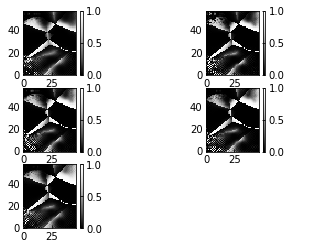

In [38]:
f, axes = plt.subplots(nrows=3, ncols=2)

e = [encoded[:, :, i, 1] for i in range(5)]

for mdl, ax in zip(e, axes.flat):

    # print("Model: ", mdl.max(), mdl.min())
    # print("Image: ", img.max(), img.min())
    im = ax.imshow(mdl, cmap="Greys_r", vmin=0, vmax=1)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

axes[-1, -1].axis("off")

# DECODER v2

To recover the sources the flux for each source is 

In [32]:

def get_n_closest_sources_decode(
    n:int,                                  # max number of sources to include
    source_locations:np.ndarray,            # locations of sources as an array of y,x idxs
    ij:Tuple[int,int],                      # the index to retrieve the sources for
) -> Tuple[List[int], Tuple[int, int]]:     # The n sources ordered by proximity idxs and the idx ij
    distances = np.linalg.norm(source_locations-np.array(ij), axis=1)
    closest_n_sources = np.argsort(distances)[:n]

    return closest_n_sources


def distribute_flux(
    modeled_vals: np.ndarray,       # [h, w, b]
    encoded: np.ndarray,            # [h, w, b, n]
    sources: np.ndarray,            # [num_srcs, h, w, b]
    source_locations: np.ndarray,   # [num_srcs, 2]
    ijb: Tuple[int, int, int],      # current location in image space
) -> None:
    i, j, b = ijb

    closest_srcs = get_n_closest_sources_decode(
        encoded.shape[-1], # n
        source_locations, # [num_Srcs, 2]
        ijb[:-1], # ij
    )

    flux_vals = modeled_vals[i, j, b] * encoded[i, j, b, :] # [n,]
    
    def update_flx(idx, flx):
        sources[idx, i, j, b] = flx

    for _ in starmap(update_flx, zip(closest_srcs, flux_vals)): pass

def decode_srcs(
    modeled_vals: np.ndarray,       # [h, w, b]
    encoded:np.ndarray,             # [h, w, b, n]
    source_locations: np.ndarray,   # [num_srcs, 2]
) -> List[np.ndarray]:
    sources = np.array([np.zeros(encoded.shape[:-1]) for _ in range(source_locations.shape[0])]) # [num_srcs, h, w, b]

    distribute_flux_f = partial(
        distribute_flux,
        modeled_vals,
        encoded,
        sources,
        source_locations
    )

    height, width, bands = modeled_vals.shape
    ijb = product(range(height), range(width), range(bands))

    for _ in map(distribute_flux_f, ijb):pass

    return sources

In [45]:
src_locations = np.array([(c["y"], c["x"]) for c in catalog])

decoded = decode_srcs(
    np.transpose(sum(model_vals), axes=(1, 2, 0)),
    encoded,
    src_locations,
)

decoded.shape

(7, 58, 48, 5)

(5, 58, 48)

In [72]:

def get_scarlet_source(
    model_frame,
    observation,
    morpheus_label:np.ndarray, 
    segmap:np.ndarray,
    source_id:int, 
    source_yx: Tuple[int, int]
) -> scarlet.component.FactorizedComponent:
    # For now go with the default scarlet recommendation of ExtendedSource with k=1
    return scarlet.ExtendedSource(model_frame, source_yx, observation)

    # sources = []
    # for k,src in enumerate(catalog):
    #     if k == 0:
    #         new_source = scarlet.PointSource(model_frame, (src['y'], src['x']), observation)
    #     elif k == 1:
    #         new_source = scarlet.ExtendedSource(model_frame, (src['y'], src['x']), observation, K=2)
    #     else:
    #         new_source = scarlet.ExtendedSource(model_frame, (src['y'], src['x']), observation)
    #     sources.append(new_source)

def get_scarlet_fit(
    filters:List[str], 
    psfs:np.ndarray, # [b, 43, 43]
    model_psf:Callable, 
    flux:np.ndarray, # [b, h, w]
    source_locations: np.ndarray,
    morpheus_label:np.ndarray, # [h, w, m]
    segmap:np.ndarray # [h, w]
):
    """Fit scarlet to image for generating labels"""


    model_frame = scarlet.Frame(
        flux.shape,
        psfs=model_psf,
        channels=filters
    )

    observation = scarlet.Observation(
        images,
        psfs=psfs,
        weights=weights,
        channels=filters,
    ).match(model_frame)

    get_source = partial(
        get_scarlet_source, 
        model_frame, 
        observation, 
        morpheus_label, 
        segmap
    )

    src_ys, src_xs = np.nonzero(source_locations)
    src_ids = source_locations[src_ys, src_xs]

    sources = list(starmap(get_source, src_ids, zip(src_ys, src_xs)))

    blend = scarlet.Blend(sources, observation)
    blend.fit(200, e_rel = 1.e-6)

    def render_source(obs, src):
        return obs.render(src.get_model(frame=src.frame))
    render_f = partial(render_source, observation)

    model_src_vals = list(map(render_f, sources))
    
    return model_src_vals

def get_claim_vector_image_and_map(
    source_locations:np.ndarray, 
    bhw:Tuple[int, int, int],
    model_src_vals:List[np.ndarray],
):
    
    # Updates claim_vector_image and claim_map_image in place
    def single_pixel_vector(
        claim_vector_image:np.ndarray,
        claim_map_image:np.ndarray,
        centers:np.ndarray, 
        i:int, 
        j:int, 
        b: inti
    ) -> None:
        connected_idxs = list(product([i, i-1, i+1], [j, j-1, j+1]))
        connected_idxs.remove((i, j))
        connected_array = np.array(connected_idxs)        

        ijb_src_flux = np.array([m[b,i,j] for m in model_src_vals])
        ijb_src_flux_mask = ijb_src_flux > 0
        
        ijb_normed_src_flux = (
            (ijb_src_flux * ijb_src_flux_mask) 
            / (ijb_src_flux * ijb_src_flux_mask).sum()
        )

        def closest_center(
            centers:np.array, 
            flux_mask:np.ndarray, 
            idx:np.ndarray
        ):
            dist = np.linalg.norm(centers-idx, axis=1)
            masked_dist = np.where(flux_mask, dist, np.inf)
            return centers[np.argmin(masked_dist)]

        closest_f = partial(closest_center, centers, ijb_src_flux_mask)
        closest_sources = np.array(list(map(closest_f, connected_array)))
        claim_vector = connected_array - closest_sources # [8]

        claim_vector_image[i, j, b, ...] = claim_vector

        def convert_to_claim_map(
            centers:np.ndarray, 
            normed_flux:np.ndarray, 
            src:np.ndarray
        ):
            return ((src==centers).all(axis=1).astype(np.float32) * normed_f_ijb).sum()

        convert_to_map_f = partial(convert_to_claim_map, centers, ijb_normed_src_flux)
        raw_claim_map = np.array(list(map(convert_to_map_f, closest_sources)))
        claim_map = raw_claim_map / raw_claim_map.sum()

        claim_map_image[i, j, b, ...] = claim_map


    n_bands, height, width = bhw
    claim_vector_image = np.zeros([height, width, n_bands, 8, 2], dtype=np.float32)
    claim_map_image = np.zeros([height, width, n_bands, 8], dtype=np.float)

    src_ys, src_xs = np.nonzero(source_locations)
    centers = np.array([src_ys, src_xs]).T # [n, 2]

    single_pixel_f = partial(
        single_pixel_vector, 
        claim_vector_image, 
        claim_map_image, 
        centers
    )

    idxs = tqdm(
        product(range(height), range(width), range(n_bands)),
        total=height*width*n_bands,
        unit="pixels" 
    )

    for _ in starmap(single_pixel_f, idxs): pass
    
    return claim_vector_image, claim_map_image
    
    
    

def build_claim_vectors_map(
    filters:List[int],
    psfs: np.ndarray,
    model_psf: Callable,
    flux_image:np.ndarray,
    source_locations:np.ndarray,
    morpheus_label:np.ndarray,
    segmap:np.ndarray
):

    # fit scarlet
    scarlet_vals = get_scarlet_fit(
        filters, 
        psfs, 
        model_psf, 
        flux_image,
        source_locations,
        morpheus_label,
        segmap,
    )
    
    # build claim vectors
    claim_vector_image = get_claim_vector_image(  
        source_locations, 
        flux_image.shape,
        scarlet_vals,
    ) # [h, w, b, 8, 2]

    # build claim map
    claim_map_image = get_claim_map_image(

    ) # [h, w, b, 8]





In [41]:
source_locations = center_point_truth
bhw = images.shape


claim_vector, claim_map = get_claim_vector_image_and_map(
    source_locations,
    bhw,
    model_vals
)

print("\n", bhw)
print(claim_vector.shape)
print(claim_map.shape)

100%|██████████| 13920/13920 [00:05&lt;00:00, 2358.71pixels/s](5, 58, 48)
(58, 48, 5, 8, 2)
(58, 48, 5, 8)



&lt;matplotlib.colorbar.Colorbar at 0x7fa11d2b3940&gt;

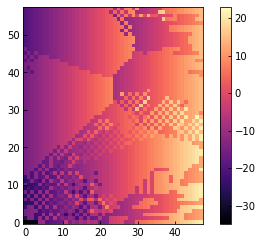

In [42]:
plt.imshow(claim_vector[:, :, 0, 0, 1])
plt.colorbar()

&lt;matplotlib.colorbar.Colorbar at 0x7fa11d01f070&gt;

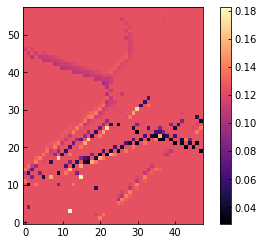

In [52]:
plt.imshow(claim_map[:, :, 0, 7])
plt.colorbar()

&lt;matplotlib.image.AxesImage at 0x7fa1301e5fa0&gt;

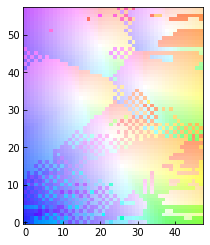

In [63]:
plt.imshow(flow_to_color(claim_vector[:, :, 4, 0, :]))

In [31]:
center_point_truth.shape

(58, 48)

In [28]:
print(model_vals[0].shape)
len(model_vals)

(5, 58, 48)


7

### Claim Vectors

Unlike in https://arxiv.org/pdf/1911.10194.pdf, where each pixel is associated with a single instance. In our setting, each pixel can be associated with multiple intances. This is encoded by considering each pixel as an 8-connected pixel where each pixel in the 8-connected set encodes an xy offset to its nearest center of mass. Enoding the data this way allows a pixel to be associated with at most 8 different sources.

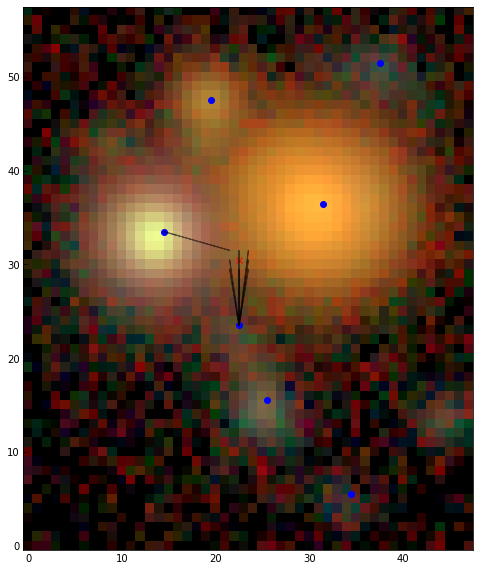

In [27]:
i = 30
j = 22
b = 0

centers = np.array([[c["y"], c["x"]] for c in catalog])

truth_img = np.zeros_like(center_point_truth)

adj_idxs = list(product([i, i-1, i+1], [j, j-1, j+1]))
adj_idxs.remove((i,j))
adj_array = np.array(adj_idxs)


f_ijb = np.array([m[b,i,j] for m in model_vals])
f_ijb_mask = f_ijb > 0

noise = max(images[b, i, j] - f_ijb.sum(), 0)

normed_f_ijb = (f_ijb * f_ijb_mask + noise) / ((f_ijb * f_ijb_mask).sum() + noise)

def closest_center(idx):
    dist = np.linalg.norm(centers-idx, axis=1)
    masked_dist = np.where(f_ijb_mask, dist, np.inf)
    return centers[np.argmin(masked_dist)]

adj_srcs = np.array(list(map(closest_center, adj_array)))
claim_vectors = adj_array - adj_srcs

f, ax = plt.subplots(figsize=(10, 10))
#ax.imshow(truth_img[20:40,10:40], cmap="Greys", origin="lower", extent=[10,40,20,40])
#ax.imshow(truth_img, cmap="Greys", origin="lower")
ax.imshow(img_rgb, origin="lower")
for c in centers:
    ax.plot(c[1]+0.5, c[0]+0.5, marker="o", color="b")


for adj, cv in zip(adj_idxs, claim_vectors):
    ax.annotate(
        "",
        xy=((adj[1]-cv[1])+0.5, (adj[0]-cv[0])+0.5),
        xycoords="data",
        xytext=(adj[1]+0.5, adj[0]+0.5),
        arrowprops=dict(facecolor='blue', width=0.2, alpha=0.5, headwidth=0.7, color="k")
    )
ax.plot(j+0.5, i+0.5, "x", color="r")

plt.savefig("contribution-vectors.pdf", dpi=600)

plt.show()

### Claim Map

The claim map encodes the ownership of the source flux in pixel $x_{ijb}$ by the source associated with each claim vector. With an additional value associated with the background flux.

In [30]:
def convert_to_claim_map(centers, normed_f_ijb, src):
    return ((src==centers).all(axis=1).astype(np.float32) * normed_f_ijb).sum()

conv_f = partial(convert_to_claim_map, centers, normed_f_ijb)
raw_claim_map = np.array(list(map(conv_f, adj_srcs)))
claim_map_vals = raw_claim_map / raw_claim_map.sum()

print(normed_f_ijb, normed_f_ijb.sum())
print(raw_claim_map, raw_claim_map.sum())
print(claim_map_vals, claim_map_vals.sum())
print(claim_map_vals.shape)

[0.61246204 0.43773462 0.09532797 0.1233441  0.09294646 0.10287874
 0.09294185] 1.5576357880349863
[0.10287874 0.10287874 0.10287874 0.10287874 0.10287874 0.10287874
 0.61246204 0.10287874] 1.332613236071186
[0.07720075 0.07720075 0.07720075 0.07720075 0.07720075 0.07720075
 0.45959475 0.07720075] 1.0
(8,)


In [24]:
model_vals[0].shape

(5, 58, 48)

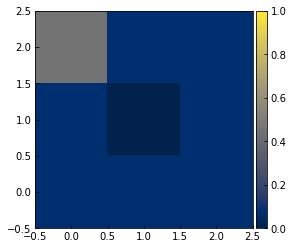

In [64]:
claim_map = np.zeros([3,3])
for (y,x), v in zip(adj_idxs - np.array(adj_idxs).min(axis=0), claim_map_vals):
    claim_map[y,x] = v

#print(claim_map)
# claim_map[1,1] = noise / 

f, ax = plt.subplots()
im = ax.imshow(claim_map, cmap="cividis", vmin=0, vmax=1, origin="lower")
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

plt.savefig("constribution-map.pdf", dpi=600)
plt.show()

How closesly do we reconstruct the Scarlet Model?

The model generated by scarlet is decomposed into claim vector and claim map representations

- claim vectors, $\mathbb{R}^{B \times H \times W \times 8 \times 2}$
- claim distribution, $\mathbb{R}^{B \times H \times W \times 9}$ 

First, lets try for a single band

In [48]:
height, width = truth_img.shape

single_band_noise = noise_image[0,...]
claim_vectors = np.zeros(list(truth_img.shape) + [8, 2], dtype=np.float32)
claim_distribution = np.zeros(list(truth_img.shape) + [9], dtype=np.float32)

centers = np.array([[c["y"], c["x"]] for c in catalog])

for i, j in tqdm(product(range(height), range(width))):
    adj_idxs = list(product([i, i-1, i+1], [j, j-1, j+1]))
    adj_idxs.remove((i,j))
    adj_array = np.array(adj_idxs)

    f_ijb = np.array([m[b,i,j] for m in model_vals] + [max(single_band_noise[i,j], 0)])
    f_ijb_mask = f_ijb > 0
    f_ijb_mask[-1] = 1
    normed_f_ijb = (f_ijb * f_ijb_mask) / (f_ijb * f_ijb_mask).sum()

    def closest_center(idx):
        dist = np.linalg.norm(centers-idx, axis=1)
        masked_dist = np.where(f_ijb_mask[:-1], dist, np.inf)
        return centers[np.argmin(masked_dist)]

    adj_srcs = np.array(list(map(closest_center, adj_array)))
    claim_vector = adj_array - adj_srcs
    claim_vectors[i, j, ...] = claim_vector

    def convert_to_claim_map(centers, normed_f_ijb, src):
        return ((src==centers).all(axis=1).astype(np.float32) * normed_f_ijb[:-1]).sum()

    conv_f = partial(convert_to_claim_map, centers, normed_f_ijb)
    raw_claim_map = np.array(list(map(conv_f, adj_srcs)))
    claim_map_vals = raw_claim_map / raw_claim_map.sum()
    claim_distribution[i,j,:-1] = claim_map_vals
    claim_distribution[i,j,-1] = single_band_noise[i,j]

2784it [00:00, 3925.77it/s]


In [49]:
recovered_sources = {i:dict(center=c, img=np.zeros([height, width])) for i,c in enumerate(centers)}
single_band = np.sum([m[0,...] for m in model_vals], axis=0)

recovered_noise = np.zeros([height, width])
for i, j in tqdm(product(range(height), range(width))):
#for i, j in product(range(height), range(width)):
    adj_idxs = list(product([i, i-1, i+1], [j, j-1, j+1]))
    adj_idxs.remove((i,j))
    adj_array = np.array(adj_idxs)


    pixel_claim_vectors = adj_array - claim_vectors[i,j,...].copy()
    pixel_claim_distribution = claim_distribution[i,j,...].copy()
    pixel_flux = single_band[i,j]

    for r in recovered_sources:
        pixel_claim_centers = pixel_claim_vectors
        claims = (pixel_claim_centers == recovered_sources[r]["center"]).all(axis=1)
        flux_claim = (claims * pixel_claim_distribution[:-1]).sum() * pixel_flux
        recovered_sources[r]["img"][i,j] = flux_claim
        recovered_noise[i,j] = pixel_flux * pixel_claim_distribution[-1]


2784it [00:00, 7961.18it/s]


In [ ]:
i, j = 0, 0


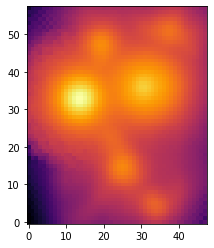

In [189]:
plt.imshow(np.log10(single_band))

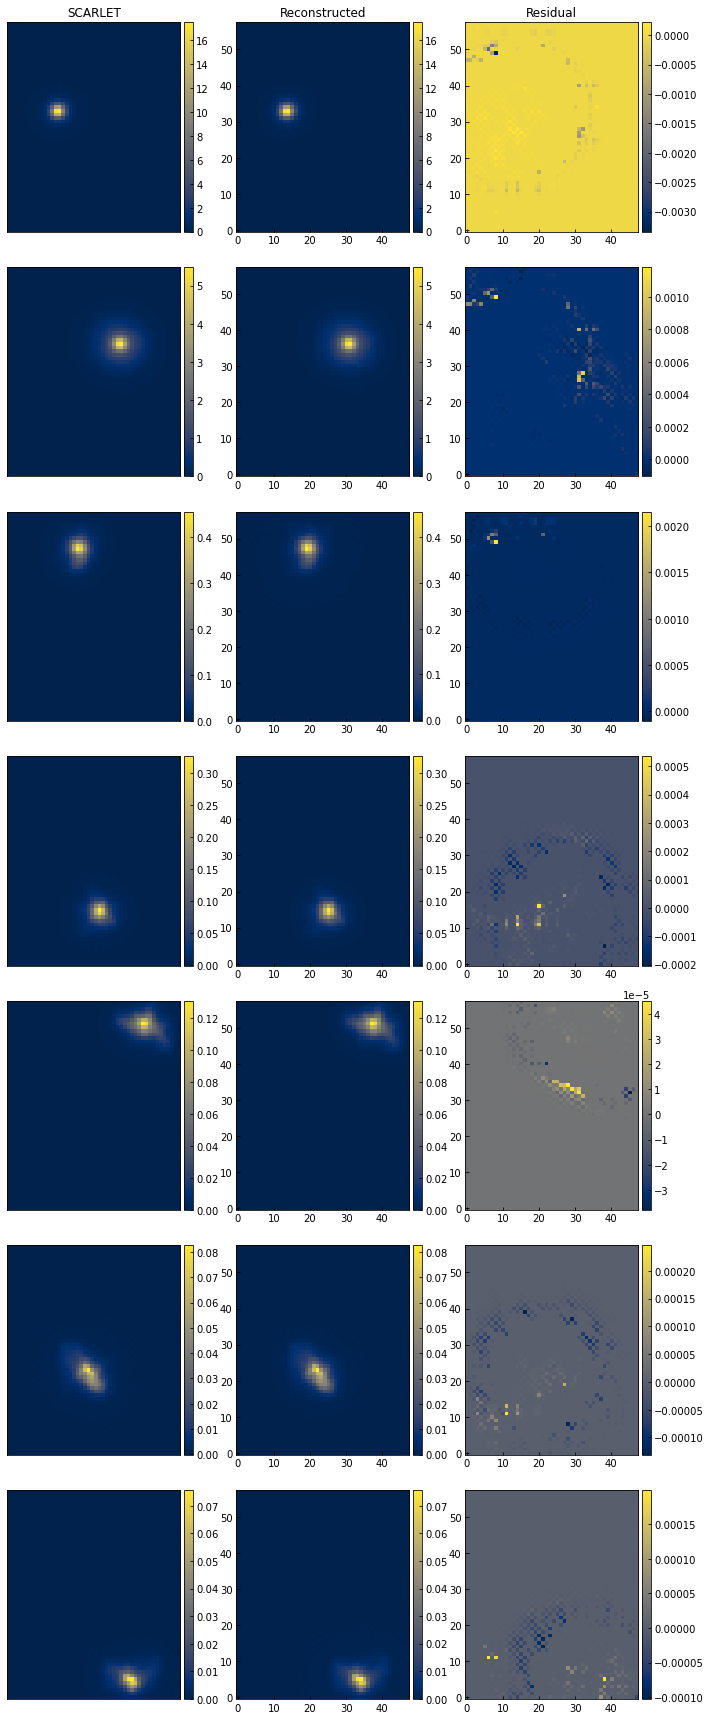

In [47]:

band = 1

f, axes = plt.subplots(nrows=7, ncols=3, figsize=(10, 24))
for source in range(len(sources)):
    im = axes[source, 0].imshow(model_vals[source][band,:,:], cmap="cividis")
    divider = make_axes_locatable(axes[source, 0])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    axes[source, 0].set_xticks([])
    axes[source, 0].set_yticks([])


    im = axes[source, 1].imshow(decoded[source, :, :, band], cmap="cividis")
    divider = make_axes_locatable(axes[source, 1])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    axes[source, 0].set_xticks([])
    axes[source, 0].set_yticks([])


    im = axes[source, 2].imshow(model_vals[source][band,:,:] - decoded[source, :, :, band], cmap="cividis")
    divider = make_axes_locatable(axes[source, 2])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    axes[source, 0].set_xticks([])
    axes[source, 0].set_yticks([])

axes[0,0].set_title("SCARLET")
axes[0,1].set_title("Reconstructed")
axes[0,2].set_title("Residual")

plt.tight_layout()
plt.savefig("source_residual.pdf", dpi=600)

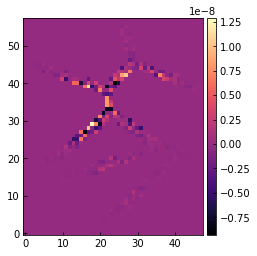

In [233]:
recovered  = sum(recovered_sources[r]["img"] for r in recovered_sources)

f, ax = plt.subplots()
im = ax.imshow(single_band-recovered, origin="lower", cmap="cividis")
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
plt.savefig("total_diff_sources.pdf", dpi=600)

In [53]:
# MIT License
#
# Copyright (c) 2018 Tom Runia
#
# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to conditions.
#
# Author: Tom Runia
# Date Created: 2018-08-03
# Reference: https://github.com/tomrunia/OpticalFlow_Visualization

import numpy as np


def make_colorwheel():
    '''
    Generates a color wheel for optical flow visualization as presented in:
        Baker et al. "A Database and Evaluation Methodology for Optical Flow" (ICCV, 2007)
        URL: http://vision.middlebury.edu/flow/flowEval-iccv07.pdf
    According to the C++ source code of Daniel Scharstein
    According to the Matlab source code of Deqing Sun
    '''

    RY = 15
    YG = 6
    GC = 4
    CB = 11
    BM = 13
    MR = 6

    ncols = RY + YG + GC + CB + BM + MR
    colorwheel = np.zeros((ncols, 3))
    col = 0

    # RY
    colorwheel[0:RY, 0] = 255
    colorwheel[0:RY, 1] = np.floor(255*np.arange(0,RY)/RY)
    col = col+RY
    # YG
    colorwheel[col:col+YG, 0] = 255 - np.floor(255*np.arange(0,YG)/YG)
    colorwheel[col:col+YG, 1] = 255
    col = col+YG
    # GC
    colorwheel[col:col+GC, 1] = 255
    colorwheel[col:col+GC, 2] = np.floor(255*np.arange(0,GC)/GC)
    col = col+GC
    # CB
    colorwheel[col:col+CB, 1] = 255 - np.floor(255*np.arange(CB)/CB)
    colorwheel[col:col+CB, 2] = 255
    col = col+CB
    # BM
    colorwheel[col:col+BM, 2] = 255
    colorwheel[col:col+BM, 0] = np.floor(255*np.arange(0,BM)/BM)
    col = col+BM
    # MR
    colorwheel[col:col+MR, 2] = 255 - np.floor(255*np.arange(MR)/MR)
    colorwheel[col:col+MR, 0] = 255
    return colorwheel


def flow_compute_color(u, v, convert_to_bgr=False):
    '''
    Applies the flow color wheel to (possibly clipped) flow components u and v.
    According to the C++ source code of Daniel Scharstein
    According to the Matlab source code of Deqing Sun
    :param u: np.ndarray, input horizontal flow
    :param v: np.ndarray, input vertical flow
    :param convert_to_bgr: bool, whether to change ordering and output BGR instead of RGB
    :return:
    '''

    flow_image = np.zeros((u.shape[0], u.shape[1], 3), np.uint8)

    colorwheel = make_colorwheel()  # shape [55x3]
    ncols = colorwheel.shape[0]

    rad = np.sqrt(np.square(u) + np.square(v))
    a = np.arctan2(-v, -u)/np.pi

    fk = (a+1) / 2*(ncols-1)
    k0 = np.floor(fk).astype(np.int32)
    k1 = k0 + 1
    k1[k1 == ncols] = 0
    f = fk - k0

    for i in range(colorwheel.shape[1]):

        tmp = colorwheel[:,i]
        col0 = tmp[k0] / 255.0
        col1 = tmp[k1] / 255.0
        col = (1-f)*col0 + f*col1

        idx = (rad <= 1)
        col[idx]  = 1 - rad[idx] * (1-col[idx])
        col[~idx] = col[~idx] * 0.75   # out of range?

        # Note the 2-i => BGR instead of RGB
        ch_idx = 2-i if convert_to_bgr else i
        flow_image[:,:,ch_idx] = np.floor(255 * col)

    return flow_image


def flow_to_color(flow_uv, clip_flow=None, convert_to_bgr=False):
    '''
    Expects a two dimensional flow image of shape [H,W,2]
    According to the C++ source code of Daniel Scharstein
    According to the Matlab source code of Deqing Sun
    :param flow_uv: np.ndarray of shape [H,W,2]
    :param clip_flow: float, maximum clipping value for flow
    :return:
    '''

    assert flow_uv.ndim == 3, 'input flow must have three dimensions'
    assert flow_uv.shape[2] == 2, 'input flow must have shape [H,W,2]'

    if clip_flow is not None:
        flow_uv = np.clip(flow_uv, 0, clip_flow)

    u = flow_uv[:,:,0]
    v = flow_uv[:,:,1]

    rad = np.sqrt(np.square(u) + np.square(v))
    rad_max = np.max(rad)

    epsilon = 1e-5
    u = u / (rad_max + epsilon)
    v = v / (rad_max + epsilon)

    return flow_compute_color(u, v, convert_to_bgr)